# FDA Project

Installing specialized packages: webdriver-manager, selenium, and wordcloud

In [1]:
pip install webdriver-manager

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install selenium

Note: you may need to restart the kernel to use updated packages.


In [3]:
conda install -c https://conda.anaconda.org/conda-forge wordcloud

Solving environment: ...working... done


Note: you may need to restart the kernel to use updated packages.
# All requested packages already installed.



In [4]:
#Importing of useful packages
import pandas as pd
import re
import numpy as np
import json
import datetime
from bs4 import BeautifulSoup as bs
import requests
import re
import urllib
import time
import os
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
#% matplotlib inline
from wordcloud import WordCloud
from collections import Counter


URL = "https://open.fda.gov/data/downloads/"

In [5]:
#The FDA website does not load the downloadable files unless you scroll to that area of the page first
#Web-Scraping involves using the Selenium webdriver to open the site with Chrome, navigate to the
    #needed area, and hit the correct buttons at the correct time

from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import selenium.common.exceptions
from selenium import webdriver
import time

from selenium.webdriver.support.wait import WebDriverWait

options = webdriver.ChromeOptions()

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.get("https://www.google.com")

driver.get(URL)
driver.maximize_window()

time.sleep(1)

#Get past the light screen
button1 = driver.find_element(By.CLASS_NAME, "button.bg-primary.clr-white")
button1.click()

time.sleep(1)
 
    #Scroll to the button for medical device events
element_link=WebDriverWait(driver, 10).until(EC.presence_of_element_located(
   (By.XPATH, '//*[@id="Medical Device Event"]')))

driver.execute_script("arguments[0].scrollIntoView(true)", element_link)

time.sleep(1)

#Click the medical device event button
button2 = driver.find_element(By.XPATH, '//*[@id="Medical Device Event"]/section/button')
button2.click()

time.sleep(1)

#Retrieve the html code now that it displays the links we need
html = driver.execute_script("return document.getElementsByTagName('html')[0].innerHTML")
#print (html)

driver.close()

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - About to download new driver from https://chromedriver.storage.googleapis.com/102.0.5005.61/chromedriver_win32.zip
[WDM] - Driver has been saved in cache [C:\Users\Allen\.wdm\drivers\chromedriver\win32\102.0.5005.61]


In [6]:
#Snip HTML to just the portion in question
pattern = '1991(.*?)<li id="Medical Device PMA">'
substring = re.search(pattern, html).group(1)

In [7]:
#Itemize links into array
import lxml.html

url_list = lxml.html.fromstring(substring)
url_list = url_list.xpath('//a/@href')
#print(newlist)

In [8]:
start_year = 2020
end_year = 2021

year_list = list(range(start_year, end_year+1))

index_to_download = []

for meh in year_list:
    for bleh in range(0, len(url_list)):
        if str(meh) in url_list[bleh]:
            index_to_download.append(url_list.index(url_list[bleh]))

index_count = len(index_to_download)

In [9]:
#Follow links in array to download/process ZIPs

#Specify Download Path
path = 'C:/Users/Allen/Documents/FDA'
#pathinverse = 'C:\Users\Allen\Documents\FDA'
import requests, zipfile
from io import BytesIO

#Filter Data by Project Code, use "All" to include all data
pcode = ["DYE","LWR","MIE","MWH","NPX","OHA","PAL","PAP"]
#pcode = ["All"]

#Run loop, opening JSONs
loopnumber = 0
datamain = ""
for snuh in index_to_download:
    print('Download ' + (str(loopnumber+1)) + " of " + (str(index_count)) + " started ")
    url = url_list[snuh]
    import requests, zipfile
    req = requests.get(url)
    print('Download ' + (str(loopnumber+1))+ " completed ")
    zipfile = zipfile.ZipFile(BytesIO(req.content))
    #filename = "FDA" + str(snuh+1)
    filename = "FDAdata.json"
    for i, f in enumerate(zipfile.filelist):
        f.filename = filename.format(i)
        zipfile.extract(f)
    print('File ' + (str(loopnumber+1))+ ' extracted')
    data = json.load(open(r'C:\Users\Allen\Documents\FDA\FDAdata.json'))
    data = data["results"]
    datamain = data
    if loopnumber == 0:
        print('Creating Dataframe with JSON ' + (str(loopnumber+1)))
        dfmain = pd.json_normalize(data,
                  record_path = "device",
                  meta = ["report_number","report_source_code","date_received","event_type","type_of_report","mdr_text"],
                  record_prefix = "_",
                  errors = "ignore")
        if pcode[0] != "All":
            dfmain = dfmain[dfmain._device_report_product_code.isin(pcode)]
        print('Dataframe Created')
    else:
        print('Appending Dataframe with JSON ' + (str(loopnumber+1)))
        dfnew = pd.json_normalize(data,
                  record_path = "device",
                  meta = ["report_number","report_source_code","date_received","event_type","type_of_report","mdr_text"],
                  record_prefix = "_",
                  errors = "ignore")
        if pcode[0] != "All":
            dfnew = dfnew[dfnew._device_report_product_code.isin(pcode)]
        dfmain = pd.concat([dfmain, dfnew])
        #dfmain.append(dfnew)
        print('JSON ' + (str(loopnumber+1)) + ' appended')
        
    os.remove(path + "/" + filename)
    loopnumber = loopnumber + 1
print("Dataframe ready")
dfmain.head()

Download 1 of 38 started 
Download 1 completed 
File 1 extracted
Creating Dataframe with JSON 1
Dataframe Created
Download 2 of 38 started 
Download 2 completed 
File 2 extracted
Appending Dataframe with JSON 2
JSON 2 appended
Download 3 of 38 started 
Download 3 completed 
File 3 extracted
Appending Dataframe with JSON 3
JSON 3 appended
Download 4 of 38 started 
Download 4 completed 
File 4 extracted
Appending Dataframe with JSON 4
JSON 4 appended
Download 5 of 38 started 
Download 5 completed 
File 5 extracted
Appending Dataframe with JSON 5
JSON 5 appended
Download 6 of 38 started 
Download 6 completed 
File 6 extracted
Appending Dataframe with JSON 6
JSON 6 appended
Download 7 of 38 started 
Download 7 completed 
File 7 extracted
Appending Dataframe with JSON 7
JSON 7 appended
Download 8 of 38 started 
Download 8 completed 
File 8 extracted
Appending Dataframe with JSON 8
JSON 8 appended
Download 9 of 38 started 
Download 9 completed 
File 9 extracted
Appending Dataframe with JSON 

,_device_event_key,_implant_flag,_date_removed_flag,_device_sequence_number,_date_received,_brand_name,_generic_name,_manufacturer_d_name,_manufacturer_d_address_1,_manufacturer_d_address_2,...,_openfda.device_class,_expiration_date_of_device,_openfda.registration_number,_openfda.fei_number,report_number,report_source_code,date_received,event_type,type_of_report,mdr_text
438,,,,1,20200320,PERCEVAL SUTURELESS AORTIC HEART VALVE,TISSUE HEART VALVE,LIVANOVA CANADA CORP.,5005 NORTH FRASER WAY,,...,3,20220415,NaN,NaN,1718850-2020-01047,Distributor report,20200320,Injury,"[Initial submission, Followup, Followup]","[{'mdr_text_key': '188982865', 'text_type_code..."
1244,,,,1,20200107,CARPENTIER-EDWARDS PERIMOUNT MAGNA MITRAL EASE...,REPLACEMENT HEART VALVE,EDWARDS LIFESCIENCES,1 EDWARDS WAY,,...,3,20220124,NaN,NaN,2015691-2020-10062,Manufacturer report,20200107,Injury,"[Initial submission, Followup, Followup]","[{'mdr_text_key': '189359014', 'text_type_code..."
1734,,,,1,20200225,INSPIRIS RESILIA AORTIC VALVE,REPLACEMENT HEART VALVE,EDWARDS LIFESCIENCES,1 EDWARDS WAY,,...,3,20191011,NaN,NaN,2015691-2020-10677,Manufacturer report,20200225,Injury,"[Initial submission, Followup, Followup, Follo...","[{'mdr_text_key': '192186743', 'text_type_code..."
3686,,,,1,20200227,CARPENTIER-EDWARDS PERIMOUNT MAGNA EASE PERICA...,REPLACEMENT HEART VALVE,EDWARDS LIFESCIENCES,1 EDWARDS WAY,,...,3,20140320,NaN,NaN,2015691-2020-10709,Manufacturer report,20200227,Injury,"[Initial submission, Followup]","[{'mdr_text_key': '190157825', 'text_type_code..."
3924,,,,1,20200305,CONTEGRA,"CONDUIT,VALVED,PULMONIC",MEDTRONIC HEART VALVE DIVISION,1851 E DEERE AVE,,...,f,20140120,NaN,NaN,2025587-2020-00676,Manufacturer report,20200305,Injury,"[Initial submission, Followup]","[{'mdr_text_key': '182170961', 'text_type_code..."


In [10]:
#dfmain.info()

#Keep only relevant columns
dfmain = dfmain[["_device_report_product_code","_brand_name","_generic_name","_manufacturer_d_name","type_of_report","report_number","report_source_code",
                 "date_received","event_type","mdr_text"]]

#Rename columns
dfmain.columns = ["product_code","brand_name","generic_name","manufacturer_name","type_of_report","report_number",
                        "report_source_code","date_received","event_type","mdr_text"]

#Update date column to date format
dfmain["date_received"] = pd.to_datetime(dfmain["date_received"])

#Remove brackets from type of report column
dfmain['type_of_report'] = dfmain['type_of_report'].str.join(', ')

#Update MDR Text to only show the text narrative items--also lowercase the text
newmdr = []
for crag in dfmain["mdr_text"]:
    newmdr.append(''.join(re.findall("'text': .+?}",str(crag))).translate(str.maketrans('', '', string.punctuation)).replace("text"," - ")[4:])

dfmain["mdr_text"] = [x.lower() for x in newmdr]
dfmain.head()

#dfmain.to_csv(r'data_test.csv', index = False)

In [32]:
dfmain = pd.read_csv("data_test.csv", encoding = 'unicode_escape')

#Remove stop words in MDR Text--we must remove null rows before this step can be done
stop_words = set(stopwords.words('english'))

#Add additional common words into stopwords
stop_words.update(["investigation","still","progress","complete","supplemental","report","filed","device","returned","reported",
                  "-","due","failure","failed","may","ensure","assures","around","met","reports","number","per","dated","patient",
                  "conclusion","performed","year","years","therefore","submitted","information","received","upon","event",
                  "events","review","required","appropriate","monitored","monitor","basis","continue","monthly","trends","completion",
                  "additional","months","yet","without","history","regarding","cause","record","established","accordingly","procedure",
                  "provided","underwent","reason","evaluation","time","related","product","severed","post","return","made","also",
                  "andor","multiple","remains","determined","replacement","definitive","issues","however","clinical","factors",
                  "effects","release","identified","cannot","reviewed","would","including","available","issued","observation",
                  "common","action"])

dfmain = dfmain[dfmain['mdr_text'].notnull()]

dfmain['mdr_text'] = dfmain['mdr_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

dfmain.head()

,product_code,brand_name,generic_name,manufacturer_name,type_of_report,report_number,report_source_code,date_received,event_type,mdr_text
0,LWR,PERCEVAL SUTURELESS AORTIC HEART VALVE,TISSUE HEART VALVE,LIVANOVA CANADA CORP.,"Initial submission, Followup, Followup",1718850-2020-01047,Distributor report,2020-03-20,Injury,manufacturer notified serious adverse involvin...
1,DYE,CARPENTIER-EDWARDS PERIMOUNT MAGNA MITRAL EASE...,REPLACEMENT HEART VALVE,EDWARDS LIFESCIENCES,"Initial submission, Followup, Followup",2015691-2020-10062,Manufacturer report,2020-01-07,Injury,although bioprosthetic valves proven excellent...
2,DYE,INSPIRIS RESILIA AORTIC VALVE,REPLACEMENT HEART VALVE,EDWARDS LIFESCIENCES,"Initial submission, Followup, Followup, Follow...",2015691-2020-10677,Manufacturer report,2020-02-25,Injury,udi b4 stenosis develops progressively additio...
3,DYE,CARPENTIER-EDWARDS PERIMOUNT MAGNA EASE PERICA...,REPLACEMENT HEART VALVE,EDWARDS LIFESCIENCES,"Initial submission, Followup",2015691-2020-10709,Manufacturer report,2020-02-27,Injury,stenosis regurgitation develops progressively ...
4,MWH,CONTEGRA,"CONDUIT,VALVED,PULMONIC",MEDTRONIC HEART VALVE DIVISION,"Initial submission, Followup",2025587-2020-00676,Manufacturer report,2020-03-05,Injury,analysis future medtronic 8 9 implant 18mm pul...


In [33]:
#dfmain = pd.read_csv("data.csv", encoding = 'unicode_escape')

no_dup = []

#Following function found from internet
def remove_duplicates(input):
 
    # split input string separated by space
    input = input.split(" ")
 
    # now create dictionary using counter method
    # which will have strings as key and their
    # frequencies as value
    UniqW = Counter(input)
 
    # joins two adjacent elements in iterable way
    s = " ".join(UniqW.keys())
    return (s)

dfmain['mdr_text_nodup'] = dfmain['mdr_text'].apply(remove_duplicates)

dfmain['mdr_text_nodup'] = dfmain['mdr_text_nodup'].map(str)

dfmain.head()

,product_code,brand_name,generic_name,manufacturer_name,type_of_report,report_number,report_source_code,date_received,event_type,mdr_text,mdr_text_nodup
0,LWR,PERCEVAL SUTURELESS AORTIC HEART VALVE,TISSUE HEART VALVE,LIVANOVA CANADA CORP.,"Initial submission, Followup, Followup",1718850-2020-01047,Distributor report,2020-03-20,Injury,manufacturer notified serious adverse involvin...,manufacturer notified serious adverse involvin...
1,DYE,CARPENTIER-EDWARDS PERIMOUNT MAGNA MITRAL EASE...,REPLACEMENT HEART VALVE,EDWARDS LIFESCIENCES,"Initial submission, Followup, Followup",2015691-2020-10062,Manufacturer report,2020-01-07,Injury,although bioprosthetic valves proven excellent...,although bioprosthetic valves proven excellent...
2,DYE,INSPIRIS RESILIA AORTIC VALVE,REPLACEMENT HEART VALVE,EDWARDS LIFESCIENCES,"Initial submission, Followup, Followup, Follow...",2015691-2020-10677,Manufacturer report,2020-02-25,Injury,udi b4 stenosis develops progressively additio...,udi b4 stenosis develops progressively additio...
3,DYE,CARPENTIER-EDWARDS PERIMOUNT MAGNA EASE PERICA...,REPLACEMENT HEART VALVE,EDWARDS LIFESCIENCES,"Initial submission, Followup",2015691-2020-10709,Manufacturer report,2020-02-27,Injury,stenosis regurgitation develops progressively ...,stenosis regurgitation develops progressively ...
4,MWH,CONTEGRA,"CONDUIT,VALVED,PULMONIC",MEDTRONIC HEART VALVE DIVISION,"Initial submission, Followup",2025587-2020-00676,Manufacturer report,2020-03-05,Injury,analysis future medtronic 8 9 implant 18mm pul...,analysis future medtronic 8 9 implant 18mm pul...


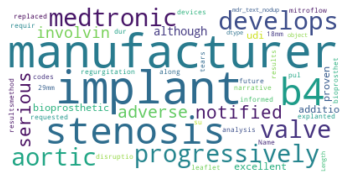

In [34]:
#Implement Word Cloud
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(str(dfmain["mdr_text_nodup"]))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('foo.png')
plt.show()

In [35]:
#Create new date field with the days removed, for visualizations

#dfmain = pd.read_csv("data.csv", encoding = 'unicode_escape')
#dfmain['mdr_text_nodup'] = dfmain['mdr_text_nodup'].map(str)

dfmain["year"] = pd.to_datetime(dfmain["date_received"], format = '%Y-%m-%d').dt.year
dfmain["month"] = pd.to_datetime(dfmain["date_received"], format = '%Y-%m-%d').dt.month

dfmain["plaindate"] = pd.to_datetime(dfmain[['year', 'month']].assign(DAY=1))

dfmain = dfmain.drop(["year","month"], 1)

dfmain.head()

#dfmain.to_csv(r'data_organ.csv', index = False)

C:\Users\Allen\AppData\Local\Temp\ipykernel_26640\1511539803.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dfmain = dfmain.drop(["year","month"], 1)


,product_code,brand_name,generic_name,manufacturer_name,type_of_report,report_number,report_source_code,date_received,event_type,mdr_text,mdr_text_nodup,plaindate
0,LWR,PERCEVAL SUTURELESS AORTIC HEART VALVE,TISSUE HEART VALVE,LIVANOVA CANADA CORP.,"Initial submission, Followup, Followup",1718850-2020-01047,Distributor report,2020-03-20,Injury,manufacturer notified serious adverse involvin...,manufacturer notified serious adverse involvin...,2020-03-01
1,DYE,CARPENTIER-EDWARDS PERIMOUNT MAGNA MITRAL EASE...,REPLACEMENT HEART VALVE,EDWARDS LIFESCIENCES,"Initial submission, Followup, Followup",2015691-2020-10062,Manufacturer report,2020-01-07,Injury,although bioprosthetic valves proven excellent...,although bioprosthetic valves proven excellent...,2020-01-01
2,DYE,INSPIRIS RESILIA AORTIC VALVE,REPLACEMENT HEART VALVE,EDWARDS LIFESCIENCES,"Initial submission, Followup, Followup, Follow...",2015691-2020-10677,Manufacturer report,2020-02-25,Injury,udi b4 stenosis develops progressively additio...,udi b4 stenosis develops progressively additio...,2020-02-01
3,DYE,CARPENTIER-EDWARDS PERIMOUNT MAGNA EASE PERICA...,REPLACEMENT HEART VALVE,EDWARDS LIFESCIENCES,"Initial submission, Followup",2015691-2020-10709,Manufacturer report,2020-02-27,Injury,stenosis regurgitation develops progressively ...,stenosis regurgitation develops progressively ...,2020-02-01
4,MWH,CONTEGRA,"CONDUIT,VALVED,PULMONIC",MEDTRONIC HEART VALVE DIVISION,"Initial submission, Followup",2025587-2020-00676,Manufacturer report,2020-03-05,Injury,analysis future medtronic 8 9 implant 18mm pul...,analysis future medtronic 8 9 implant 18mm pul...,2020-03-01


In [36]:
dfmain.head()

,product_code,brand_name,generic_name,manufacturer_name,type_of_report,report_number,report_source_code,date_received,event_type,mdr_text,mdr_text_nodup,plaindate
0,LWR,PERCEVAL SUTURELESS AORTIC HEART VALVE,TISSUE HEART VALVE,LIVANOVA CANADA CORP.,"Initial submission, Followup, Followup",1718850-2020-01047,Distributor report,2020-03-20,Injury,manufacturer notified serious adverse involvin...,manufacturer notified serious adverse involvin...,2020-03-01
1,DYE,CARPENTIER-EDWARDS PERIMOUNT MAGNA MITRAL EASE...,REPLACEMENT HEART VALVE,EDWARDS LIFESCIENCES,"Initial submission, Followup, Followup",2015691-2020-10062,Manufacturer report,2020-01-07,Injury,although bioprosthetic valves proven excellent...,although bioprosthetic valves proven excellent...,2020-01-01
2,DYE,INSPIRIS RESILIA AORTIC VALVE,REPLACEMENT HEART VALVE,EDWARDS LIFESCIENCES,"Initial submission, Followup, Followup, Follow...",2015691-2020-10677,Manufacturer report,2020-02-25,Injury,udi b4 stenosis develops progressively additio...,udi b4 stenosis develops progressively additio...,2020-02-01
3,DYE,CARPENTIER-EDWARDS PERIMOUNT MAGNA EASE PERICA...,REPLACEMENT HEART VALVE,EDWARDS LIFESCIENCES,"Initial submission, Followup",2015691-2020-10709,Manufacturer report,2020-02-27,Injury,stenosis regurgitation develops progressively ...,stenosis regurgitation develops progressively ...,2020-02-01
4,MWH,CONTEGRA,"CONDUIT,VALVED,PULMONIC",MEDTRONIC HEART VALVE DIVISION,"Initial submission, Followup",2025587-2020-00676,Manufacturer report,2020-03-05,Injury,analysis future medtronic 8 9 implant 18mm pul...,analysis future medtronic 8 9 implant 18mm pul...,2020-03-01


In [37]:
#Create new dataframe--list of unique words in data, separated by month
#dfmain = pd.read_csv("data_vent.csv", encoding = 'unicode_escape')
dfmain['mdr_text_nodup'] = dfmain['mdr_text_nodup'].map(str)

dfword = pd.DataFrame()

#Create unique list of dates to be used in the for loop
datelist = dfmain["plaindate"].unique()

#Loop to create dataframe of unique words and the number of times they each appear
wordnumbers = []
for squid in datelist:
    wordnumbers = Counter(' '.join(map(lambda l: ''.join(l), dfmain.loc[dfmain["plaindate"] == squid]["mdr_text_nodup"])).split(" ")) 
    dftemp = pd.DataFrame.from_dict(wordnumbers, orient='index').reset_index()
    dftemp["Date"] = squid
    dfword = pd.concat([dfword, dftemp])
    
dfword.columns = ["word","counts","date"]

#dfword = dfword.drop(dfword[dfword.counts < 100].index)

dfword.head()
dfword.to_csv(r'word_heart5.csv', index = False)

In [17]:
dfword.head()

,word,counts,date
0,manufacturer,29,2020-03-01
1,notified,39,2020-03-01
2,serious,14,2020-03-01
3,adverse,133,2020-03-01
4,involving,5,2020-03-01


In [18]:
#dfword = pd.DataFrame.from_dict(wordnumbers, orient='index').reset_index()
#dfmain.head()

In [19]:
#dfmain.head()

#dfmain.to_csv(r'data.csv', index = False)